## 의료용 마스크 탐지 모델
- https://pseudo-lab.github.io/Tutorial-Book/chapters/object-detection/intro.html

⛄ 의료용 마스크 탐지 모델
마스크를 착용한 사람, 착용하지 않은 사람 또는 마스크를 부적절하게 착용한 사람을 감지하는 모델을 만들기



👁‍🗨 데이터 세트
3 가지 클래스 에 속하는 853 개의 이미지 와 PASCAL VOC 형식의 경계 상자가 포함
- 마스크 포함
- 마스크 없이
- 마스크를 잘못 착용

👁‍🗨images와 annotations 폴더
- images 폴더에는 이미지 파일이 0부터 852
- annotations 폴더에는 xml 파일이 0부터 852
    - annotations 폴더 안에 있는 xml 파일들은 각각의 이미지 파일의 정보
        - 폴더명과 파일명이 나오며, 이미지 크기 정보가 포함되어 있는 걸 확인
        - mask_weared_incorrect의 경우 마스크를 제대로 쓰지 않은 객체의 정보
        - with_mask는 마스크를 착용하고 있는 객체 위치 정보
        - without_mask은 마스크를 쓰지 않은 객체의 정보
        - bndbox안에는 xmin, ymin, xmax, ymax가 순서대로 있음 바운딩 박스 영역을 지정하는 정보

#### 1. 데이터 검증

In [79]:
import torch

In [80]:
torch.__version__

'1.7.0+cu101'

In [81]:
import os
import glob                             # 파일을 다루는데 널리 쓰임
import matplotlib.pyplot as plt         # 시각화
import matplotlib.image as mpimg        
import matplotlib.patches as patches    
from bs4 import BeautifulSoup           # HTML과 XML 문서 파일을 파싱(Parsing), 웹스크래핑(Web Scraping)에 유용

from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import os
import random

- glob 패키지를 이용해 데이터셋을 불러옴
- sorted 함수를 사용해 img_list에 있는 파일의 id 순서와 annot_list에 있는 파일의 id 순서가 같도록 함

In [82]:
img_list = sorted(glob.glob('archive/images/*'))
annot_list = sorted(glob.glob('archive/annotations/*'))

In [83]:
print(len(img_list))
print(len(annot_list))

853
853


In [84]:
print(img_list[:10])
print(annot_list[:10])

['archive/images/maksssksksss0.png', 'archive/images/maksssksksss1.png', 'archive/images/maksssksksss10.png', 'archive/images/maksssksksss100.png', 'archive/images/maksssksksss101.png', 'archive/images/maksssksksss102.png', 'archive/images/maksssksksss103.png', 'archive/images/maksssksksss104.png', 'archive/images/maksssksksss105.png', 'archive/images/maksssksksss106.png']
['archive/annotations/maksssksksss0.xml', 'archive/annotations/maksssksksss1.xml', 'archive/annotations/maksssksksss10.xml', 'archive/annotations/maksssksksss100.xml', 'archive/annotations/maksssksksss101.xml', 'archive/annotations/maksssksksss102.xml', 'archive/annotations/maksssksksss103.xml', 'archive/annotations/maksssksksss104.xml', 'archive/annotations/maksssksksss105.xml', 'archive/annotations/maksssksksss106.xml']


#### 2. 바운딩 박스 시각화를 위한 함수를 정의

In [85]:
def generate_box(obj):
    # xmin, ymin, xmax, ymax 값을 반환

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # 마스크 착용 여부를 세단계로 나눠서 0, 1, 2 값을 반환
    # with_mask의 경우 1
    # mask_weared_incorrect의 경우 2
    # without_mask는 0

    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    # generate_box와 generate_label를 각각 호출하여 반환된 값을 딕셔너리에 저장해 반환

    with open(file) as f:
        data = f.read()

        # annotations 파일에 있는 내용들을 불러와 타겟의 바운딩 박스와 라벨을 추출
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image(img_path, annotation):
    # 이미지와 바운딩 박스를 함께 시각화

    img = mpimg.imread(img_path)
    
    fig, ax = plt.subplots(1)
    ax.imshow(img)

    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        # 마스크 착용시 초록색
        # 마스크를 올바르게 착용 안했을 시 주황색
        # 마스크를 착용 안했을 시 빨간색 바운딩 박스
        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

- 인덱스 값 확인

In [86]:
img_list.index('archive/images/maksssksksss307.png') 

232

- generate_target 함수를 활용해 maksssksksss307.png 파일에 해당하는 바운딩 박스 정보를 bbox에 저
- plot_image 함수에 바운딩 박스 정보와 더불어 해당 이미지 파일 정보도 넘겨주어 이미지 위에 바운딩 박스를 시각화
- img_list[]와 annot_list[]안의 숫자는 maksssksksss307.png 파일의 위치를 뜻하므로 같은 숫자가 들어가 있음

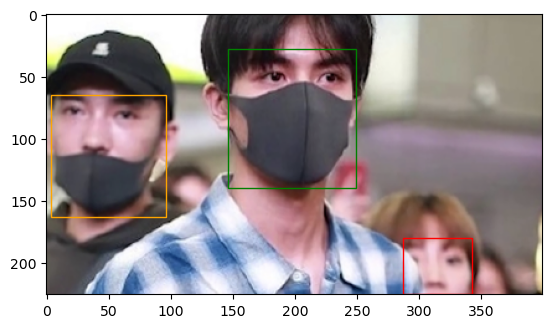

In [87]:
bbox = generate_target(annot_list[232])
plot_image(img_list[232], bbox)

#### 3. 데이터 전처리

- augmentation : 데이터 증강법
    - torchvision.transforms는 파이토치에서 공식적으로 제공
        - 바운딩 박스 변형 기능 없음
    - albumentations는 OpenCV와 같은 오픈 소스 컴퓨터 비젼 라이브러리를 최적화 하였기에 다른 라이브러리보다 더 빠른 처리 속도 및 기타 기능을 제공
        - 객체 탐지용 이미지 augmentation은 이미지 뿐만 아니라 바운딩 박스까지 변형을 주어야 함

In [102]:
!git clone https://github.com/Pseudo-Lab/Tutorial-Book-Utils
!python Tutorial-Book-Utils/PL_data_loader.py --data FaceMaskDetection
!unzip -q Face\ Mask\ Detection.zip

fatal: destination path 'Tutorial-Book-Utils' already exists and is not an empty directory.
Downloading...
From: https://drive.google.com/uc?id=1pJtohTc9NGNRzHj5IsySR39JIRPfkgD3
To: /home/ubuntu/2022/ObjectDetection/Face Mask Detection.zip
100%|████████████████████████████████████████| 417M/417M [00:52<00:00, 7.97MB/s]
Face Mask Detection.zip download complete!


In [92]:
!pip install --upgrade albumentations

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.9/16.9 MB 5.8 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.4
    Uninstalling numpy-1.23.4:
      Successfully uninstalled numpy-1.23.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.2 requires libclang>=9.0.1, which is not installed.
tensorflow 2.8.2 requires tensorflow-io-gcs-filesystem>=0.23.1, which is not installed.
tensorflow 2.8.2 requires protobuf<3.20,>=3.9.2, but you have protobuf 3.20.1 which is incompatible.


- augmentation 결과물을 시각화

In [103]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from bs4 import BeautifulSoup

def generate_box(obj):
    # xmin, ymin, xmax, ymax 값을 반환

    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):
    # 마스크 착용 여부를 세단계로 나눠서 0, 1, 2 값을 반환
    # with_mask의 경우 1
    # mask_weared_incorrect의 경우 2
    # without_mask는 0

    if obj.find('name').text == "with_mask":
        return 1
    elif obj.find('name').text == "mask_weared_incorrect":
        return 2
    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        # 딥러닝 모델 학습을 위한 tensor간의 연산을 준비하기 위해  torch.as_tensor함수가 추가
        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target



def plot_image_from_output(img, annotation):
    # 이미지와 바운딩 박스를 함께 시각화
    # torch.Tensor로 변환된 이미지를 시각화
        # PyTorch에서는 이미지를 [channels, height, width]로 표현
        # matplotlib에서는 [height, width, channels]로 표현

    img = img.permute(1,2,0)
    # 채널 순서를 바꿔주는 permute함수를 활용해 matplotlib의 채널 순서로 바꿈
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        # 마스크 착용시 초록색
        # 마스크를 올바르게 착용 안했을 시 주황색
        # 마스크를 착용 안했을 시 빨간색 바운딩 박스

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

#### 1) torchvision.transforms을 실습

In [104]:
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
from matplotlib import pyplot as plt
import os
import random

class TorchvisionMaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):         # image를 불러온 다음 데이터 augmentation을 진행
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        
        target = generate_target(label_path)
        
        start_t = time.time()
        if self.transform:                  # transform 파라미터에 저장돼 있는 augmentation 규칙에 따라 augmentation이 이뤄짐
            img = self.transform(img)

        total_time = (time.time() - start_t)        # 시간 측정을 위해 time함수를 사용

        # 최종적으로 image, label, total_time을 반환
        return img, target, total_time

- 이미지 augmentation 실습을 진행
    - 이미지를 (300, 300) 크기로 만든 후, 224 크기로 자르기
    - 이미지의 밝기(brightness), 대비(contrast), 채도(saturation), 색조(hue)를 무작위로 바꾸기
    - 이미지 좌우 반전을 적용한 후 tensor로 변환하는 작업을 진행

In [105]:
torchvision_transform = transforms.Compose([
    transforms.Resize((300, 300)), 
    transforms.RandomCrop(224),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomHorizontalFlip(p = 1),
    transforms.ToTensor(),
])

torchvision_dataset = TorchvisionMaskDataset(
    path = 'images/',
    transform = torchvision_transform
)

- transforms에서 제공하는 Resize 함수를 통해 이미지 크기를 조정
- RandomCrop 함수를 통해 이미지를 자를 수 있음
- ColorJitter 함수는 밝기, 대비, 채도, 색조 등을 임의로 바꾸는 기능
- RandomHorizontalFlip은 정의한 p의 확률로 좌우반전을 실시
- 변경 전과 변경 후의 이미지를 비교

transforms 적용 전


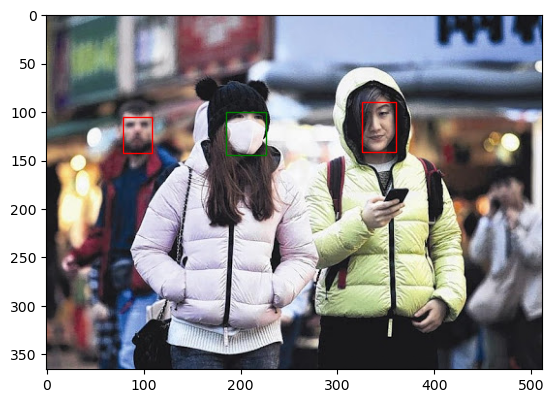

In [106]:
only_totensor = transforms.Compose([transforms.ToTensor()])

torchvision_dataset_no_transform = TorchvisionMaskDataset(
    path = 'images/',
    transform = only_totensor
)

img, annot, transform_time = torchvision_dataset_no_transform[0]
print('transforms 적용 전')
plot_image_from_output(img, annot) 

- 변경 전에 비해 변경 후 이미지는 앞서 언급한 변화들이 적용됨
- 이미지 자체적인 변화는 이뤄졌지만 바운딩 박스는 변화된 이미지에서 위치가 어긋난 것을 확인
- torchvision.transform에서 제공하는 augmentation은 이미지 값에 대한 augmentation만 진행이 되며,
- 바운딩 박스는 같이 변환되지 않음
    - =>  이미지가 변해도 라벨값이 고정이지만, 객체 검출 문제에서는 이미지가 변함에 따라 라벨 값 또한 함께 변해야 함

transforms 적용 후


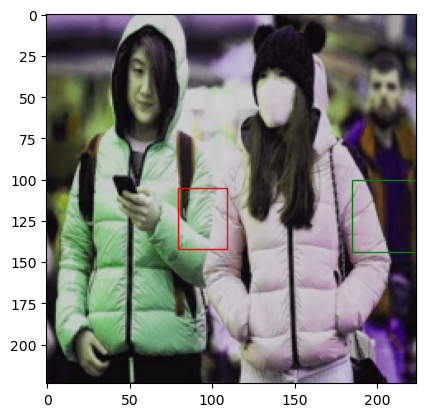

In [107]:
img, annot, transform_time = torchvision_dataset[0]

print('transforms 적용 후')
plot_image_from_output(img, annot)

 - torchvision_dataset에서 이미지 변환에 소요된 시간을 계산하고 그것을 100번 반복한 시간

In [108]:
total_time = 0
for i in range(100):
  sample, _, transform_time = torchvision_dataset[0]
  total_time += transform_time

print("torchvision time: {} ms".format(total_time*10))

torchvision time: 5.949978828430176 ms


#### 2) Albumentations
- cv2 모듈을 사용하여 이미지를 읽고 RGB로 바꿔줌
- 이미지 변환을 실시한 후 결과값을 반환

In [109]:
class AlbumentationsDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        # Read an image with OpenCV
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        start_t = time.time()
        if self.transform:
            augmented = self.transform(image=image)
            total_time = (time.time() - start_t)
            image = augmented['image']
        
            
        return image, target, total_time

- albumentations_transform 속도 비교

In [110]:
# Same transform with torchvision_transform
albumentations_transform = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.ColorJitter(p=1), 
    albumentations.HorizontalFlip(p=1), 
    albumentations.pytorch.transforms.ToTensorV2()
])

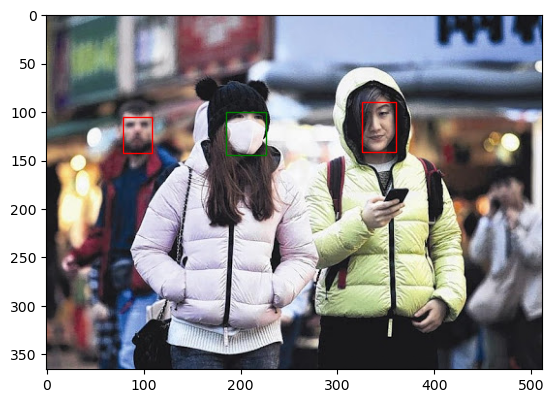

In [111]:
# 변경 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output(img, annot)

-  이미지 변환이 이루어 졌지만, 바운딩 박스는 변하지 않은 것

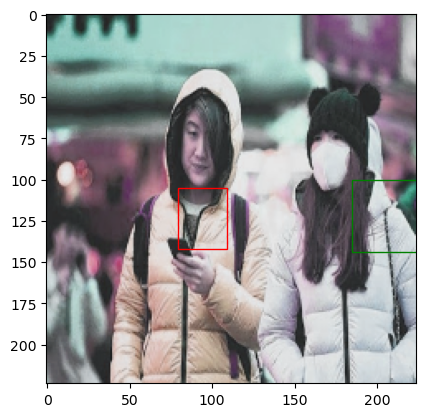

In [112]:
# 변경 후
albumentation_dataset = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform
)

img, annot, transform_time = albumentation_dataset[0]
plot_image_from_output(img, annot)

- 속도 측정을 위해 albumentation을 100번 적용 시킨 뒤 시간을 측정

In [113]:
total_time = 0
for i in range(100):
    sample, _, transform_time = albumentation_dataset[0]
    total_time += transform_time

print("albumentations time/sample: {} ms".format(total_time*10))

albumentations time/sample: 0.9501218795776367 ms


#### 3) 확률 기반 Augmentation 조합
- Albumentations에서 제공하는 OneOf 함수
- list 안에 있는 augmentation 기능 들을 주어진 확률 값에 기반하여 가져옴
    - list 값 자체의 확률 값과 더불어 해당 함수의 확률 값을 함께 고려하여 실행 여부를 결정
- OneOf 함수는 각각 선택될 확률이 1
- 각각의 함수 내부에 있는 3개의 albumentations 기능들 또한 각각 확률 값이 1로 부여
- 실질적으로 1/3의 확률로 3개의 기능 중 하나가 선택되어 실행된다는 것을 알 수 있음
- 확률 값을 조정하여 다양한 augmentation이 가능

In [114]:
albumentations_transform_oneof = albumentations.Compose([
    albumentations.Resize(300, 300), 
    albumentations.RandomCrop(224, 224),
    albumentations.OneOf([
                          albumentations.HorizontalFlip(p=1),
                          albumentations.RandomRotate90(p=1),
                          albumentations.VerticalFlip(p=1)            
    ], p=1),
    albumentations.OneOf([
                          albumentations.MotionBlur(p=1),
                          albumentations.OpticalDistortion(p=1),
                          albumentations.GaussNoise(p=1)                 
    ], p=1),
    albumentations.pytorch.ToTensorV2()
])

-  albumentations_transform_oneof를 이미지에 10번 적용한 결과

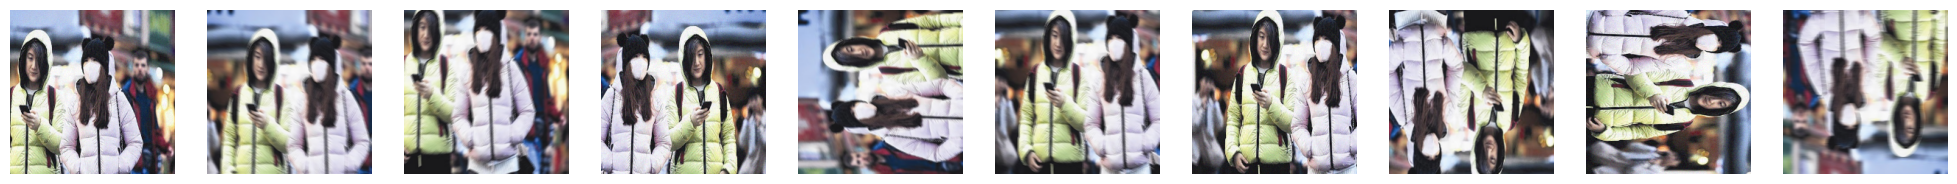

In [115]:
albumentation_dataset_oneof = AlbumentationsDataset(
    path = 'images/',
    transform = albumentations_transform_oneof
)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize=(25, 5))
for i in range(num_samples):
  ax[i].imshow(transforms.ToPILImage()(albumentation_dataset_oneof[0][0]))
  ax[i].axis('off')

#### 4) 바운딩 박스 Augmentation
- 바운딩 박스를 함께 변환 시켜 주지 않으면 바운딩 박스가 엉뚱한 곳을 탐지하고 있기 때문에 모델 학습이 제대로 이뤄지지 않음
- Albumentations에서 제공하는 Compose 함수에 있는 bbox_params 파라미터를 활용하면 바운딩 박스 augmentation이 가능

- 새로운 데이터셋 클래스를 생성
    - AlbumentationsDataset 클래스의 transform 부분을 수정
    - 이미지뿐만 아니라 바운딩 박스도 transform이 진행되기 때문에 필요한 입력값, 출력값 수정을 진행

In [116]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

- albumentations.Compose 함수를 활용해 변환을 정의
- 가장 먼저 좌우반전을 실시할 것이며, 그 이후에 -90도에서 90도 사이의 회전을 진행
- 바운딩 박스도 함께 변환을 진행해주기 위해 bbox_params 파라미터에 albumentations.BboxParams 객체를 입력
- Face Mask Detection 데이터셋은 바운딩 박스 표기법이 xmin, ymin, xmax, ymax으로 돼 있고, 이것은 pascal_voc 표기법과 같음
- format 파라미터에 pascal_voc을 입력
- transform 진행 시 객체별 클래스 값은 labels 파라미터에 저장해두기 위해 label_field에 labels를 입력

In [117]:
bbox_transform = albumentations.Compose(
    [albumentations.HorizontalFlip(p=1),
     albumentations.Rotate(p=1),
     albumentations.pytorch.transforms.ToTensorV2()],
    bbox_params=albumentations.BboxParams(format='pascal_voc', label_fields=['labels']),
)

- BboxAugmentationDataset 클래스를 활성화 하여 augmentation 결과물을 확인
    - 코드를 실행할 때마다 이미지가 변환되어서 출력
    - 바운딩 박스 또한 알맞게 변환되어 변환된 이미지에 있는 마스크 착용 얼굴들을 정확히 탐지

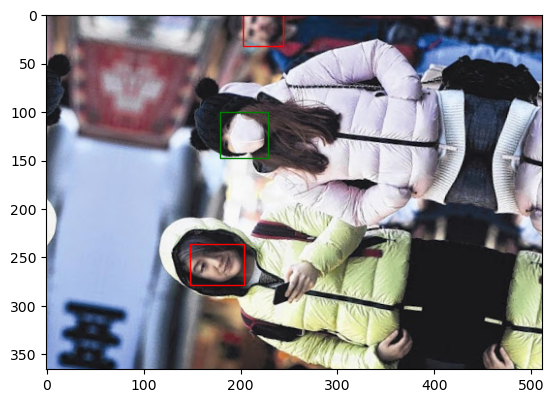

In [118]:
bbox_transform_dataset = BboxAugmentationDataset(
    path = 'images/',
    transform = bbox_transform
)

img, annot = bbox_transform_dataset[0]
plot_image_from_output(img, annot)

#### 4. 데이터 분리
- 인공지능 모델을 구축하기 위해선 학습용 데이터와 시험 데이터가 필요
    - 학습용 데이터는 모델 훈련 시 사용
    - 시험 데이터는 모델 평가 시 사용
    - 시험 데이터는 학습용 데이터와 중복되지 않아야 함

In [119]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))

853
853


- 일반적으로 학습 데이터와 시험 데이터의 비율은 7:3 (여기서는 8:2 비율)
- 해당 데이터를 별도의 폴더로 옮겨 주도록 함

In [120]:
!mkdir test_images
!mkdir test_annotations

- images 폴더와 annotations 폴더에 있는 파일 각각 170개씩을 새로 생성한 폴더로 옮기기
- random 모듈에 있는 sample 함수를 활용해 무작위로 숫자를 추출한 후 인덱스값으로 활용

In [121]:
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


- shutil 패키지를 활용해 170개의 이미지와 170개의 좌표 파일들을 각각 test_images폴더와 test_annotations 폴더로 옮김
- 각 폴더별 파일 개수를 확인

In [122]:
import numpy as np
import shutil

for img in np.array(sorted(os.listdir('images')))[idx]:
    shutil.move('images/'+img, 'test_images/'+img)

for annot in np.array(sorted(os.listdir('annotations')))[idx]:
    shutil.move('annotations/'+annot, 'test_annotations/'+annot)

In [123]:
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_annotations')))
print(len(os.listdir('test_images')))

683
683
170
170


- 객체 탐지 문제에서는 각 클래스 별로 몇 개의 객체가 데이터셋 내부에 존재하는지 확인하는 작업이 필요
- 데이터셋 내부에 있는 클래스별 객체 수를 확인
    - 학습용 데이터에는 532개의 0번 클래스, 2,691개의 1번 클래스, 97개의 2번 클래스가 위치
    - 시험용 데이터에는 185개의 0번 클래스, 541개의 1번 클래스, 26개의 2번 클래스가 위치
    - 데이터셋별로 0,1,2 비율이 유사한 것을 보아 적절히 데이터가 나뉘어 진 것을 확인

In [124]:
from tqdm import tqdm
import pandas as pd
from collections import Counter

def get_num_objects_for_each_class(dataset):
    # 데이터셋에 있는 모든 바운딩 박스의 라벨 값을 total_labels에 저장 후 
    # Counter 클래스를 활용해 라벨별 개수를 세어 반환하는 함수
    total_labels = []
    for img, annot in tqdm(dataset, position = 0, leave = True):
        total_labels += [int(i) for i in annot['labels']]

    return Counter(total_labels)

train_data =  BboxAugmentationDataset(
    path = 'images/'
)

test_data =  BboxAugmentationDataset(
    path = 'test_images/'
)

train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)

print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

100%|██████████| 170/170 [00:01<00:00, 101.22it/s]


 train 데이터에 있는 객체 Counter({1: 2691, 0: 532, 2: 97})

 test 데이터에 있는 객체 Counter({1: 541, 0: 185, 2: 26})


#### 5) RetinaNet
- torchvision에서 제공하는 one-stage 모델인 RetinaNet을 활용해 의료용 마스크 검출 모델을 구축

- 데이터 불러오기

In [131]:
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
from bs4 import BeautifulSoup
from PIL import Image
import cv2
import numpy as np
import time
import torch
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
from matplotlib import pyplot as plt
import os

def generate_box(obj):
    
    xmin = float(obj.find('xmin').text)
    ymin = float(obj.find('ymin').text)
    xmax = float(obj.find('xmax').text)
    ymax = float(obj.find('ymax').text)
    
    return [xmin, ymin, xmax, ymax]

def generate_label(obj):

    if obj.find('name').text == "with_mask":

        return 1

    elif obj.find('name').text == "mask_weared_incorrect":

        return 2

    return 0

def generate_target(file): 
    with open(file) as f:
        data = f.read()
        soup = BeautifulSoup(data, "html.parser")
        objects = soup.find_all("object")

        num_objs = len(objects)

        boxes = []
        labels = []
        for i in objects:
            boxes.append(generate_box(i))
            labels.append(generate_label(i))

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        
        return target

def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    rects = []

    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 0 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 1 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        rects.append(rect)

    return img, rects

class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)
        
        if 'test' in self.path:
            label_path = os.path.join("test_annotations/", file_label)
        else:
            label_path = os.path.join("annotations/", file_label)

        img = Image.open(img_path).convert("RGB")
        target = generate_target(label_path)
        
        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            img, transform_target = self.transform(np.array(img), np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)

        # tensor로 변경
        img = to_tensor(img)


        return img, target

def collate_fn(batch):
    return tuple(zip(*batch))

dataset = MaskDataset('images/')
test_dataset = MaskDataset('test_images/')

data_loader = torch.utils.data.DataLoader(dataset, batch_size=4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=2, collate_fn=collate_fn)

In [125]:
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
  Using cached https://download.pytorch.org/whl/cu101/torch-1.7.0%2Bcu101-cp38-cp38-linux_x86_64.whl (735.3 MB)
  Using cached https://download.pytorch.org/whl/cu101/torchvision-0.8.1%2Bcu101-cp38-cp38-linux_x86_64.whl (12.8 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.13.0
    Uninstalling torch-1.13.0:
      Successfully uninstalled torch-1.13.0
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.14.0
    Uninstalling torchvision-0.14.0:
      Successfully uninstalled torchvision-0.14.0


In [126]:
import torchvision
import torch

In [127]:
torchvision.__version__

'0.8.1+cu101'

- RetinaNet 모델을 불러오기
- Face Mask Detection 데이터셋에 3개의 클래스가 존재하므로 num_classes 매개변수를 3으로 정의
- 전이 학습을 할 것이기 때문에 backbone 구조는 사전 학습 된 가중치를, 그 외 가중치는 초기화 상태로 가져오기
    - backbone은 객체 탐지 데이터셋으로 유명한 COCO 데이터셋에 사전 학습됨

In [128]:
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained=False, pretrained_backbone = True)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /home/ubuntu/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

#### 6. 전이학습

In [134]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

num_epochs = 1
retina.to(device)
    
# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 params만 추출
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

len_dataloader = len(data_loader)

# epoch 당 약 4분 소요
for epoch in range(num_epochs):
    start = time.time()
    retina.train()

    i = 0    
    epoch_loss = 0
    for images, targets in data_loader:
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = retina(images, targets) 

        losses = sum(loss for loss in loss_dict.values()) 

        i += 1

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        
        epoch_loss += losses 
    print(epoch_loss, f'time: {time.time() - start}')

KeyboardInterrupt: 

In [ ]:
torch.save(retina.state_dict(),f'retina_{num_epochs}.pt')

In [ ]:
retina.load_state_dict(torch.load(f'retina_{num_epochs}.pt'))